<a href="https://colab.research.google.com/github/AilingLiu/Complete-Analysis-on-Travel-Bookings-in-Time-Series-Manner/blob/master/Analysis_on_travel_bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is to fullfill a travel booking agency take home test to assess analysis knowledge. It comprises of 4 tasks, with reference of 2 different datasets.

# Set up

In [0]:
# check Python version is 3.5 and later
import sys
sys.version_info >= (3, 5)

# check sklearn version is 0.20 and later
import sklearn
sklearn.__version__ >= '0.20'

# common imports
import os
import numpy as np

# figure settings
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# where to save the figures
PROJECT_ROOT_DIR='.'
PROJECT_ID = 'GYG_THT'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', PROJECT_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(figure_id, image_path=IMAGE_PATH, fig_extension='png', tight_layout=True, dpi=300):
  path=os.path.join(image_path, figure_id + '.' + fig_extension)
  print('Saving images: ', figure_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=dpi)

# Get Data

In [0]:
# where to download the data and where to store the data
URL_PATH_Q1 = 'https://raw.githubusercontent.com/AilingLiu/Complete-Analysis-on-Travel-Bookings-in-Time-Series-Manner/master/datasets/analytics_tht_q1.csv' 
URL_PATH_Q2 = 'https://raw.githubusercontent.com/AilingLiu/Complete-Analysis-on-Travel-Bookings-in-Time-Series-Manner/master/datasets/analytics_tht_Q2.csv'
DATA_PATH = os.path.join('datasets', PROJECT_ID)

import urllib

def fetch_data_q1(url_path=URL_PATH_Q1, data_path=DATA_PATH):
  path = os.path.join(data_path, 'data1.csv')
  if not os.path.isdir(data_path):
    os.makedirs(data_path)
  try:
    urllib.request.urlretrieve(url_path, path)
    print('Dataset is downloaded in: \n', path)
    return path
  except:
    print('Please check your url validity.')

In [0]:
CSV_PATH1 = fetch_data_q1()

Dataset is downloaded in: 
 datasets/GYG_THT/data1.csv


In [0]:
# take a quick look of dataset
!head -n 2 'datasets/GYG_THT/data1.csv'

order_id,booking_id,customer_id,net_revenue,gross_merchandise_value,date_of_checkout,date_of_travel,activity_category,device_id
ea647a26545133eb1178627c660eb307,79110c8c61651a17c71d36d1ff400902,2e08815f0bc331f3c8239676b9755701,76.41611349016657,362.8098901392762,2017-08-04T23:31:19.000+02:00,2017-08-06T20:00:00.000+02:00,City Cruise,1


In [0]:
import pandas as pd

def load_data_q1(csv_path=CSV_PATH1):
  return pd.read_csv(csv_path)

In [0]:
bookings = load_data_q1()
bookings.head()

,order_id,booking_id,customer_id,net_revenue,gross_merchandise_value,date_of_checkout,date_of_travel,activity_category,device_id
0,ea647a26545133eb1178627c660eb307,79110c8c61651a17c71d36d1ff400902,2e08815f0bc331f3c8239676b9755701,76.416113,362.809890,2017-08-04T23:31:19.000+02:00,2017-08-06T20:00:00.000+02:00,City Cruise,1
1,c9d995fdd3f8f46113f72719428e58c0,cb3f1a6b758322c3750297bbbba75162,99a84ab22128410a7ca82a8848314880,30.105888,100.377201,2018-07-08T15:48:15.000+02:00,2018-07-11T12:15:00.000+02:00,City Cruise,3
2,838a05584192eab5758dc76eb8754382,1d84c6ef74f4213bc111a31230e75d18,7d2de46dab587a091d4d795f3466ec02,16.083138,41.534976,2017-08-17T15:45:36.000+02:00,2017-08-17T09:30:00.000+02:00,Attraction Ticket,3
3,c552f12c32f6e4eaf8b67b088ba263ed,bf7f177122241fb49d8905a3c22a28c8,c8899bd2bdc56ef116a38ec0f2c2cfa2,13.950031,76.161595,2017-08-31T05:33:30.000+02:00,2017-09-02T14:15:00.000+02:00,Attraction Ticket,2
4,7474f90401e812a747c518061a0e964c,2b1b6db082b298d7a69d683d9415ecfe,e408bdd3d03e4f4189f48f0e8e9c2ec2,12.713799,51.909630,2018-08-20T19:35:47.000+02:00,2018-08-21T10:00:00.000+02:00,Attraction Ticket,2


# (Optional)

This part is used to have quick look at the data structure, for self reference only. Toggle this to skip to tasks solutions directly.

This dataset consists of 9 attributes. According to THT guidelines, below is a list of descriptions of the attributes.

* `order_id`: Uniquely identifies a shopping cart.
* `booking_id`: Uniquely identifies a booking.
* `customer_id`: Uniquely identifiers a customer
* `net_revenue`: This is a calculated metric that equals GMV less our basic costs
* `gross_merchandise_value`: The Gross Merchandise Value (gmv)
* `date_of_checkout`: Indicates the date and time of checkout. Format is: YYYY-MM-DD HH:MM:SS
* `date_of_travel`: Indicates the date when activity will take place. Format is: YYYY-MM-DD HH:MM:SS
* `activity_category`: Our groupings of activities.
* `device_id Uniquely`: identifies a device. Device refers to technology devices, such as desktop, mobile and tablet


In [0]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137988 entries, 0 to 137987
Data columns (total 9 columns):
order_id                   137988 non-null object
booking_id                 137988 non-null object
customer_id                137988 non-null object
net_revenue                137988 non-null float64
gross_merchandise_value    137988 non-null float64
date_of_checkout           137988 non-null object
date_of_travel             137988 non-null object
activity_category          131254 non-null object
device_id                  137988 non-null int64
dtypes: float64(2), int64(1), object(6)
memory usage: 9.5+ MB


<b>shape of dataset</b>

This dataset has 137,988 rows, 9 columns. Not a large dataset, to split dev and validation set, we can consider using .3 as validation set ratio.

<b>data types</b>

- It has 6 `categorical` attributes (in pandas it's registered as `object`). 
- The `device_id` is read as `int64`. In general sense, id is nominal values. Consider to convert it into `object` for upcoming device type analysis.
- `net_revenue` and `gross_merchandise_value` are numerical type `float64`. 

<b> To check </b>: Using $$NR=GMV-COST$$ we can deduce the cost amount: $$COST=GMV-NR$$
<b>nonnull values</b>

There are missing values in `activity_category` attribute. Other attributes are complete. 

In [0]:
bookings.describe().iloc[:, :-1]

,net_revenue,gross_merchandise_value
count,137988.000000,137988.000000
mean,33.051721,132.356857
std,35.736766,141.728076
min,-19.549436,0.000000
25%,12.573208,50.988515
50%,23.536890,92.075054
75%,41.328937,163.994676
max,1143.417760,5251.720124


As `net_revenue` shows, 75% of orders are below ${€}$41 per order. Some of the order/orders appear to be losing revenue. 
On the other hand, `gross_merchandise_value` shows 75% of orders are below ${€}$164 per order. Some of th order/orders do not make any gross revenue. The standard deviation of 142 indicates a significant dispersion of data. (In other words: some orders generate significantly different gross values, either very small or very large, for merchandises. 


Saving images:  booking_nr_and_gmv_histogram


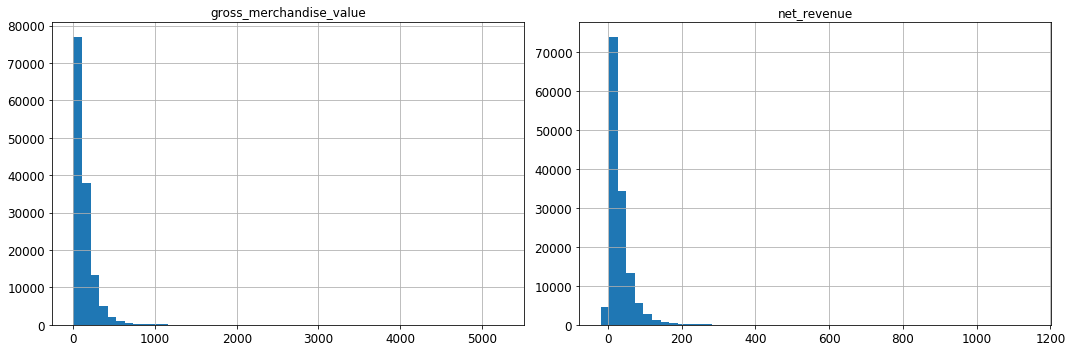

In [0]:
# Let's take a look at the gross value and net revenue histogram
bookings.iloc[:, :-1].hist(bins=50, figsize=(15, 5));
save_fig('booking_nr_and_gmv_histogram')

Both `net_revenue` and `gross_merchandise_values` are tail-heavy to the right. If we were to build any regression models, we need to transform it into a more noralized shape (e.g. 0-mean standardization).

# Task 1

## 1.1 
- <b> Clean the dataset. Point out anything you find, that required cleaning. </b>


---



**Solutions and Justifications:**

* Null values

In the overview section, using `.info` pandas method we can see that `activity_category` attribute has missing values. There are three general approaches to tackle null values: delete the rows containing null values, delete the attribute that contains null values, or impute values with sensible approaches.

As `activity_category` is categorical type, we can impute the missing values using the most freaquent strategy, i.e. `Attraction Ticket` in this dataset, to proximate the trend of dominant type. However, it will also introduce bias, especially when the ratio of mi

ssing values are large. Here, the missing values a sall ratio (5%) of the entire data, to be more confident we can drop the rows that containing missing values.

In [0]:
# back up the data for exploraty analysis
booking = bookings.copy()

# Let's make sure one attribute `activity_category` has missing vaules while other attributes are complete
print('Percentage of Null Values by Attribute: \n ')
print(bookings.isnull().mean().round(4)*100)

# Take a look of categories of `activity_category`
print('\nPercentae of each category in Activity: \n')
print(bookings.activity_category.value_counts(dropna=False, normalize=True))

# Take a look at the rows where `activity_category` is null
print('\npreview of rows with missing values: \n')
display(bookings[bookings['activity_category'].isnull()].sample(5, random_state=42))

# Dropping the rows contain missing values in `activity_category`
print('\nCleaning Missing values... ')
booking.dropna(axis=0, subset=['activity_category'], inplace=True)
print('\nAny missing values left after cleaning: ', booking['activity_category'].isnull().any())

Percentage of Null Values by Attribute: 
 
order_id                   0.00
booking_id                 0.00
customer_id                0.00
net_revenue                0.00
gross_merchandise_value    0.00
date_of_checkout           0.00
date_of_travel             0.00
activity_category          4.88
device_id                  0.00
dtype: float64

Percentae of each category in Activity: 

Attraction Ticket          0.327702
Day Trip                   0.161688
Attraction Walking Tour    0.137744
City Cruise                0.097632
City Motorized Tour        0.068086
City Walking Tour          0.056802
NaN                        0.048801
Hop On Hop Off             0.033597
Other                      0.031988
Transfer                   0.019219
City Card                  0.014545
Multi Day Trip             0.002196
Name: activity_category, dtype: float64

preview of rows with missing values: 



,order_id,booking_id,customer_id,net_revenue,gross_merchandise_value,date_of_checkout,date_of_travel,activity_category,device_id
7410,e53803ef6e427da9d5411ff8e4bb9ebd,ad99fd356192671555834beb8299d5d3,6ea311325dd5073d39b66362ea765162,20.288751,101.467994,2017-06-27T18:54:57.000+02:00,2017-06-27T08:30:00.000+02:00,NaN,3
96082,62690861e425b15940116f7af703758a,4a7abd77104e007062033444d8191c02,3b3aba2fd9280063c57b772f2a6f67a2,0.000000,0.000000,2017-10-20T15:43:36.000+02:00,2017-10-31T08:45:00.000+01:00,NaN,1
114153,059991eb0367bf1da98568c2c62537bd,563dd8a931d8699a597b50d593c56f76,2df1bbd250977f4b363055989ecc19f2,140.518385,439.116924,2017-05-02T01:33:50.000+02:00,2017-08-03T09:15:00.000+02:00,NaN,1
40999,79ef335fdad8c6c6492a4efdd14394be,4311311cbc01b5828a78d134ad387c6b,45fa204abd87d861d0a713cc8431dc80,0.000000,0.000000,2017-12-28T21:33:53.000+01:00,2018-01-15T11:00:00.000+01:00,NaN,1
44523,c3c4e3c6a91c9d95e07773d86978fd28,7aadd0712a1534a668aecfb716ef4244,f7aeb84e8d4a41e182670b3045987d72,73.883050,441.662108,2018-04-03T03:58:21.000+02:00,2018-07-19T13:00:00.000+02:00,NaN,1



Cleaning Missing values... 

Any missing values left after cleaning:  False


* duplicated rows

There are four attributes indicate unique identifier. It would be ideal for analysis if any of these is a primary key, i.e. a unique id for each row without duplicated id in any other rows. How to verify which id is the unique id? If the number of unique id in the attribute is equivalent to the total number of rows, then we get our answer.

In [0]:
# checking which id is identifier by uniqueness ratio among the entire set
id_columns = [col for col in booking.columns if 'id' in col]
booking[id_columns].nunique()/len(booking)

order_id       0.897436
booking_id     0.951575
customer_id    0.721022
device_id      0.000038
dtype: float64

Apparently, `booking_id` has the largest potential to be unique identity. But let's take a look of duplicated rows first.

In [0]:
# check a sample of duplicated rows where values at all columns are identical
dulicated_booking= booking[booking.duplicated(keep=False)].sort_values(by='booking_id')
dulicated_booking.head()

,order_id,booking_id,customer_id,net_revenue,gross_merchandise_value,date_of_checkout,date_of_travel,activity_category,device_id
97894,b2bbda16c2392390b119d089d799a5d8,00012e6528a8d7f6ce683e4bade263b7,ddf93037d79a12e0c81a620e92b252b1,23.694449,89.142032,2018-04-21T18:58:51.000+02:00,2018-04-21T20:45:00.000+02:00,City Walking Tour,1
129623,b2bbda16c2392390b119d089d799a5d8,00012e6528a8d7f6ce683e4bade263b7,ddf93037d79a12e0c81a620e92b252b1,23.694449,89.142032,2018-04-21T18:58:51.000+02:00,2018-04-21T20:45:00.000+02:00,City Walking Tour,1
95021,094846097aeb2b1129993ae914b9dc78,00047553fda1288645dfdc522b7b9e50,0c99129bae23ccacee7507d5a6e4b140,25.185200,71.095467,2018-04-23T03:07:35.000+02:00,2018-04-27T09:30:00.000+02:00,Hop On Hop Off,2
96800,094846097aeb2b1129993ae914b9dc78,00047553fda1288645dfdc522b7b9e50,0c99129bae23ccacee7507d5a6e4b140,25.185200,71.095467,2018-04-23T03:07:35.000+02:00,2018-04-27T09:30:00.000+02:00,Hop On Hop Off,2
115730,e9c6430fc12c22f7714bbd4b6f1df75b,0015e5c2011bf1c22153a5a2a4998240,b9dca31e9d9edf69ed09ce97863b82c1,88.523916,338.497325,2018-04-18T18:00:04.000+02:00,2018-06-01T18:00:00.000+02:00,City Cruise,2


In [0]:
# the total number of duplicated booking_id
print('The total number of duplicated rows: ')
print(booking.duplicated().sum())

# Let's get rid of these rows
print('\ndroping dulicated rows...')
booking.drop_duplicates(inplace=True)
booking[id_columns].nunique()/len(booking)

The total number of duplicated rows: 
6356

droping dulicated rows...


order_id       0.943106
booking_id     1.000000
customer_id    0.757714
device_id      0.000040
dtype: float64

Indeed, after cleaning duplicated rows, `booking_id` has rised to become the primary key of this dataset, i.e. each row contains a unique booking id. Notice that `order_id` attribute still has small ratio of duplicated ids, regardless of `booking_id` is different. What contributes to this difference? This is beyond the topic. If you are interested in how I find the solution, read through. Otherwise, toggle below section to go to next task.

### (Optional) 

What makes the `order_id` identical under different `different booking_id`?

In [0]:
# check a sample of duplicated orders
dulicated_order= booking[booking.duplicated(subset='order_id', keep=False)].sort_values(by='order_id')
display(dulicated_order.head()) # looks like each `date_of_travel` is different, while `date_of_checkout` is the same

# check if the number of `date_of_checkout` uniqueness is aligned with `order_id`
dulicated_order.order_id.nunique() == dulicated_order.date_of_checkout.nunique() #This means that the same `order_id` has the same `date_of_checkout` time.

,order_id,booking_id,customer_id,net_revenue,gross_merchandise_value,date_of_checkout,date_of_travel,activity_category,device_id
100132,00090095e1865307934fc86c75f46fef,c9d8fdf12f996c85f7da55c9e19bddab,63c1fe933b709a6999160de57d807c70,72.016582,224.727609,2017-04-13T04:49:41.000+02:00,2017-06-16T10:30:00.000+02:00,Day Trip,1
65732,00090095e1865307934fc86c75f46fef,c46a97de1b57d4c7e3bff0668e7506f2,63c1fe933b709a6999160de57d807c70,119.999356,342.860497,2017-04-13T04:49:41.000+02:00,2017-06-14T07:00:00.000+02:00,Day Trip,1
82531,001e10595687bab6870d262ba2bc1f54,efeb26896c12b94cada61c28f77dd35b,f823fcde41e9661c76a4380c9edf82d1,23.827768,87.457363,2018-06-19T19:42:55.000+02:00,2018-07-06T08:00:00.000+02:00,Day Trip,1
81175,001e10595687bab6870d262ba2bc1f54,f06b4744afcffead6ba23c0caaeb5316,f823fcde41e9661c76a4380c9edf82d1,40.844140,149.923445,2018-06-19T19:42:55.000+02:00,2018-07-08T06:50:00.000+02:00,Day Trip,1
88811,001e10595687bab6870d262ba2bc1f54,1be449f519befc1508574d9f6c18dad5,f823fcde41e9661c76a4380c9edf82d1,52.115668,162.406966,2018-06-19T19:42:55.000+02:00,2018-07-05T08:55:00.000+02:00,Day Trip,1


True



---


## 1.2
- <b> Plot a count of bookings over time. Point out anything you notice about the timeseries. </b>


---


- `date_of_checkout` analysis & `date_of_travel` analysis

  * How many bookings over time
  * How much net revenue (NR) GYG gain over the year?

In [0]:
# First, let's convert the `date_of_checkout` and `date_of_travel` into pandas datetime format
booking['date_of_checkout'] = pd.to_datetime(booking['date_of_checkout'], utc=True)
booking['date_of_travel'] = pd.to_datetime(booking['date_of_travel'], utc=True)
booking.head()

,order_id,booking_id,customer_id,net_revenue,gross_merchandise_value,date_of_checkout,date_of_travel,activity_category,device_id
0,ea647a26545133eb1178627c660eb307,79110c8c61651a17c71d36d1ff400902,2e08815f0bc331f3c8239676b9755701,76.416113,362.809890,2017-08-04 21:31:19+00:00,2017-08-06 18:00:00+00:00,City Cruise,1
1,c9d995fdd3f8f46113f72719428e58c0,cb3f1a6b758322c3750297bbbba75162,99a84ab22128410a7ca82a8848314880,30.105888,100.377201,2018-07-08 13:48:15+00:00,2018-07-11 10:15:00+00:00,City Cruise,3
2,838a05584192eab5758dc76eb8754382,1d84c6ef74f4213bc111a31230e75d18,7d2de46dab587a091d4d795f3466ec02,16.083138,41.534976,2017-08-17 13:45:36+00:00,2017-08-17 07:30:00+00:00,Attraction Ticket,3
3,c552f12c32f6e4eaf8b67b088ba263ed,bf7f177122241fb49d8905a3c22a28c8,c8899bd2bdc56ef116a38ec0f2c2cfa2,13.950031,76.161595,2017-08-31 03:33:30+00:00,2017-09-02 12:15:00+00:00,Attraction Ticket,2
4,7474f90401e812a747c518061a0e964c,2b1b6db082b298d7a69d683d9415ecfe,e408bdd3d03e4f4189f48f0e8e9c2ec2,12.713799,51.909630,2018-08-20 17:35:47+00:00,2018-08-21 08:00:00+00:00,Attraction Ticket,2


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


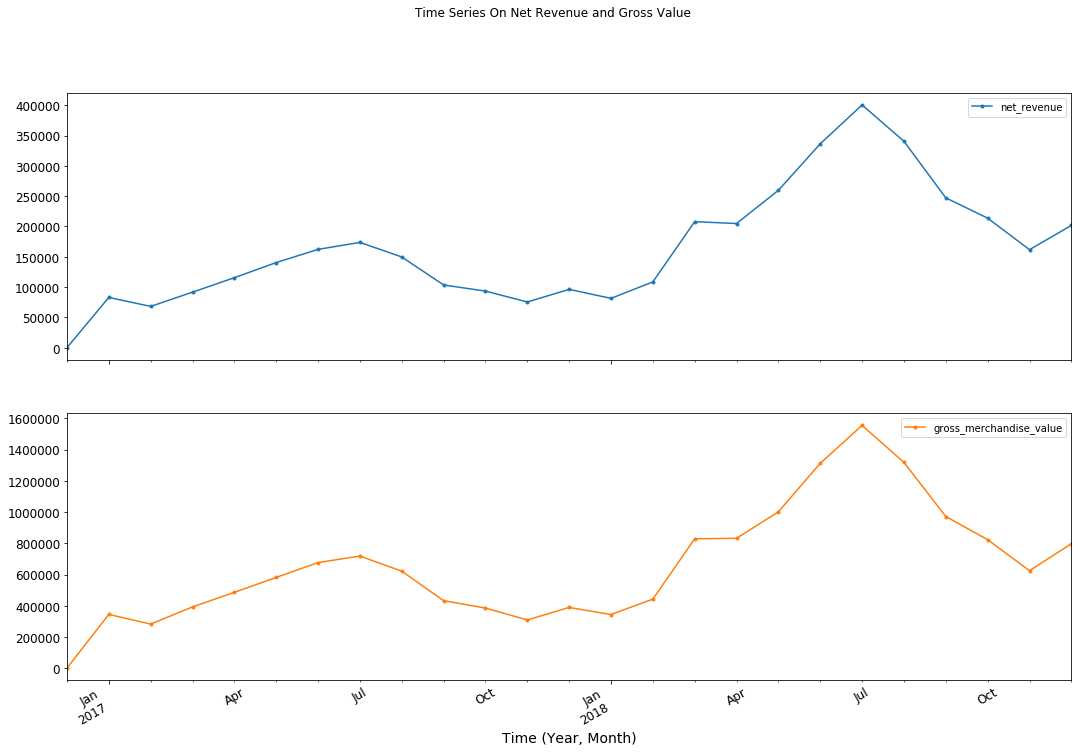

Saving images:  nr_gmv_over_time_lineplot


<Figure size 432x288 with 0 Axes>

In [0]:
booking_by_checkout = booking.groupby(booking.date_of_checkout.dt.to_period('M'))[['net_revenue', 'gross_merchandise_value']].sum()
booking_by_checkout.plot(subplots=True,
                           sharex=True,
                           figsize=(18,12),
                           marker='o',
                           markersize=3,
                         title='Time Series On Net Revenue and Gross Value')
plt.xlabel('Time (Year, Month)')
plt.show()

save_fig('nr_gmv_over_time_lineplot')

**Solution and Justification**

Net revenue and gross merchandise value have the same trends, where the peaks are in summer July in both 2017 and 2018, from where the value go down and reach to lowest in winter November. Based on this behavior, marketing team may offer campaigns in winter in order to boost revenues.

Compared to 2017, both net revenue and gross merchandise value almost double in summer in 2018. If we want to find out what causes this drastic change, we can collect extra attributes to investigate further.

## 1.3

---


* <b> Analyse our activity categories. Tell us anything interesting you find about how they differ in net revenue (NR) and gross merchandise value (GMV). Are there
other differences between categories that you notice? </b>



Saving images:  Barplot_of_monetary_value_by_Activity


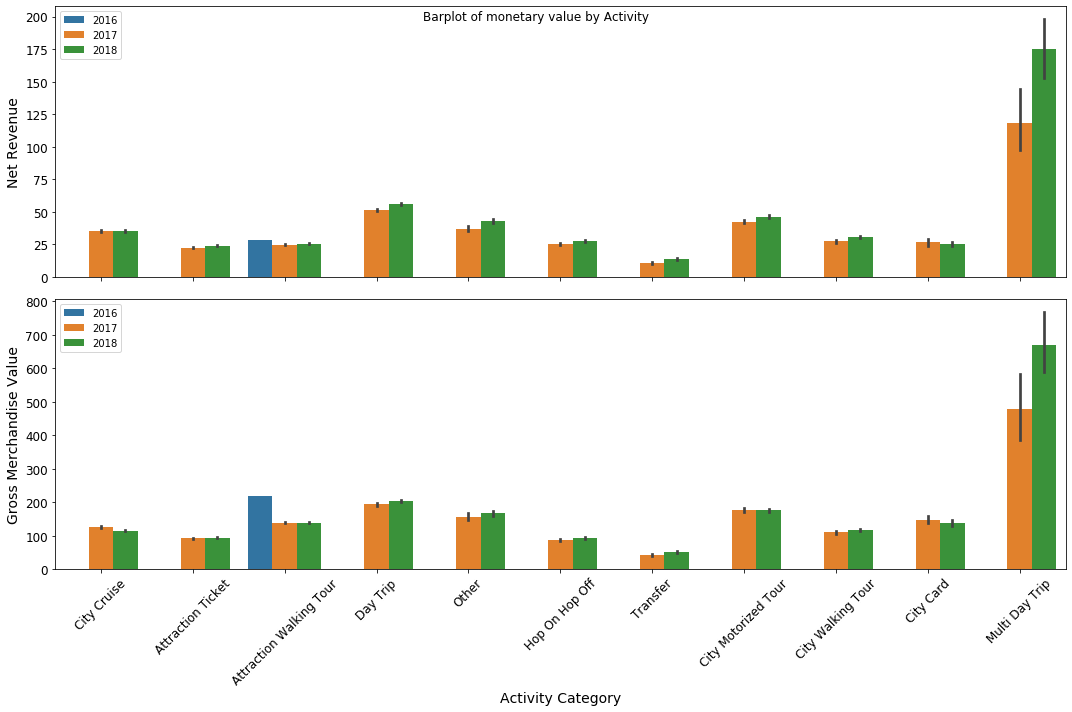

In [0]:
# import seaborn
import seaborn as sns

# Create a barplot with each activity by year shown as a different color
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

sns.barplot(data=booking,
         y='net_revenue',
         x='activity_category',
         hue=booking.date_of_checkout.dt.year,
         ax=ax1)
ax1.set_ylabel('Net Revenue')
ax1.legend(loc='upper left')
ax1.set_xlabel('')
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

sns.barplot(data=booking,
         y='gross_merchandise_value',
         x='activity_category',
         hue=booking.date_of_checkout.dt.year,
         ax=ax2)
ax2.set_ylabel('Gross Merchandise Value')
ax2.legend(loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_xlabel('Activity Category')

fig.suptitle('Barplot of monetary value by Activity')
plt.subplots_adjust(hspace=0.6)

save_fig('Barplot_of_monetary_value_by_Activity')

Before jumping to any conclusions, let's also calculate the yearly commision rate (nr/gmv) and average cost per booking by categories and years.

In [0]:
rev_ = booking.groupby([booking.activity_category, booking.date_of_checkout.dt.year])[['net_revenue', 'gross_merchandise_value']].sum()
rev_['nr_yearly_ratio'] = (rev_.net_revenue/rev_.gross_merchandise_value)*100
rev_ = rev_.round(2).unstack('date_of_checkout', fill_value=0)

booking['cost_ratio'] = ((booking['gross_merchandise_value'] - booking['net_revenue'])/booking['gross_merchandise_value']).round(2)
cost_summary_by_activity = booking.groupby([booking.activity_category, booking.date_of_checkout.dt.year])['cost_ratio'].mean().to_frame('avg_cost_percentage')
cost_ = (cost_summary_by_activity*100).round(2).unstack('date_of_checkout',fill_value=0)

pd.concat([rev_, cost_], axis=1)

net_revenue             ... avg_cost_percentage       
date_of_checkout               2016       2017  ...                2017   2018
activity_category                               ...                           
Attraction Ticket               0.0  306726.45  ...               75.49  74.44
Attraction Walking Tour        28.4  163399.06  ...               82.35  81.88
City Card                       0.0   17343.11  ...               83.67  82.98
City Cruise                     0.0  177525.10  ...               69.08  66.88
City Motorized Tour             0.0  135733.66  ...               75.28  73.26
City Walking Tour               0.0   70647.37  ...               74.73  73.21
Day Trip                        0.0  354288.14  ...               72.83  71.62
Hop On Hop Off                  0.0   46742.35  ...               72.03  70.55
Multi Day Trip                  0.0   11841.46  ...               74.42  71.87
Other                           0.0   57677.73  ...               75.62  73.90
Transfer                        0.0   10900.36  ...               75.60  74.03

[11 rows x 12 columns]

**Solution and Justification:**

Above two graphs show the distribution of bookings with <b>Net Revenue (NR)</b> and <b>Gross Merchandise Value(GMV)</b> by activity and years in different colors. The <b>`Multi Day Trip`</b> is the most profitable product in terms of net amount by each booking, with a long tail in high end indicating extreme large amount (outlier) gained from consumers. This might be caused by the choise of different city under the same product. The average of GMV in this category is ${€}$605, leading to average ${€}$156 NR.

The 2nd and 3rd profitable products are <b>`Day Trip`</b> and <b>`City Motorized Tour`</b> in 2017 and 2018.

Notice that it shows <b>`Attraction Walking Tour`</b> had a booking whose NR was the second largest in 2016, this number is supported by only 1 booking and such category does not exist in 2017 nor 2018. If we are interested in reviving this product, we can collect more data in this category for investigation.

Although the largest NR is gained from <b>`Multi Day Trip`</b>,  due to high cost ratio, its profitable ratio falls behind <b>`City Cruise`</b> (<u>2017: 28.01% </u>, <u>2018: 30.52%</u>) and <b>`Hop On and Hop Off`</b> (<u>2017: 28.50%</u>, <u>2018: 29.94%</u>) product. If we shift focus to high return ratio, we can certainly come up with marketing campaign on these two products.

Besides revenue, our cost of each activity products see about 1-3% of drop from 2017 to 2018. `City Cruise`'s cost drops by 3.8%, followed by `Multi Day Trip` by 2.6%.

## 1.4

* <b> Some devices have unique booking behaviour. What is unique about device_ids 4 and 5? </b>


---



In [0]:
# convert `device_id` to categorical type
booking['device_id'] = booking['device_id'].astype('object')

# subset the data to reduce analysis to only 2017 and 2018, due to the lack of data of 2016
booking_2017_2018 = booking[booking.date_of_checkout.dt.year >= 2017]
device_group = booking_2017_2018.groupby([booking_2017_2018.device_id, booking_2017_2018.date_of_checkout.dt.year])
device_user = device_group['customer_id'].nunique().to_frame('number_of_customers').unstack('date_of_checkout', fill_value=0)
device_rev = device_group['net_revenue'].sum().to_frame('total_revenue').unstack('date_of_checkout', fill_value=0)


display(device_user)
display(device_rev.round(2))

number_of_customers       
date_of_checkout                2017   2018
device_id                                  
1                              16907  28783
2                              13586  27919
3                               3150   4895
4                               1138   3081
5                                244    672

total_revenue            
date_of_checkout          2017        2018
device_id                                 
1                    761041.43  1468027.92
2                    414105.22   918902.55
3                    120479.94   208321.68
4                     47286.24   140590.41
5                      9911.96    28325.03

**Solution and Justification**

From 2017 to 2018, the user base ratio of device 4 and 5 has increased drastically by almost tripple. More interestingly, they lead to huge impact on revenue by 3 to 4 times more from 2017 to 2018. We can consider to transfer the similar technology/campaign strategy from these two devices to other three devices 1 to 3.

# Task 2



---


This data set is based on our shopping cart data. We would like you to discover an insight into our business using this data set. You can take your analysis in any direction you like. We are looking to understand how you think about the business and how you would analyse a data set with no specific question being asked.

Tip: A good place to start is to think of a business question based on the data
provided.

Description of attributes:


* `date_of_creation`: Indicates the creation date. Format is: YYYY-MM-DD HH:MM:SS.
* `date_of_checkout`: Indicates the date and time of checkout. Format is: YYYY-MM-DD HH:MM:SS
* `bookings`: Indicates the total number of bookings associated with a shopping cart. A shopping cart can have one or more bookings.
* `purchase_type_id`: Uniquely identifies the type of purchase. Typical purchase types include 'Repeat' which indicates a repeat customer, and 'Same Trip' which indicates the shopping cart is for the same trip.
* `is_fraud`: Indicates if fraud is involved
* `week`: Indicates the week of creation.
* `tour_category_id`: Uniquely identifies a tour category.
* `date_of_travel`: Indicates the date when activity will take place. Format is: YYYY-MM-DD HH:MM:SS
* `shopping_cart_id_a`: Uniquely identifies a shopping cart. Shopping carts are also commonly referred to as baskets or orders.
* `customer_id_a`: Uniquely identifies a customer
* `customer_address_id_a`: Uniquely identifies a customer address
* `billing_id_a Uniquely`: identifies a billing. You can think of the billing as the 'transaction' associated with payment for bookings in the shopping cart. That is, a billing is essentially a shopping cart that has been paid for.
* `coupon_id_a`: Unique identifier of a coupon, if applied.
* `reseller_id_a`: Uniquely identifies a reseller. Resellers are also commonly referred to as 'partners'
* `gyg_campaign_id_a`: Uniquely identifies a GetYourGuide (gyg) campaign.
* `currency_id_a`: Uniquely identifies the currency
* `shopping_cart_status_id_a`: Uniquely identifies a status for a shopping cart
* `coupon_segment_id_a`: Uniquely identifies a coupon segment. A coupon segment is a grouping of a set of coupons
* `attribution_id_a`: Uniquely identifies an attribution. Attribution indicates the marketing channel from which the booking originated
* `device_id_a`: Uniquely identifies a device. Device refers to technology devices, such as desktop, mobile and tablet
* `exchange_rate_a`: Indicates the multiplication factor for converting to euros. If no conversion is required then this column has a 1.
* `gmv_a`: The Gross Merchandise Value (gmv)
* `gmv_after_coupons_a` The Gross Merchandise Value (gmv) expressed in the local currency
* `visitor_id_a` Uniquely identifies a visitor to a site or app. A potential customer is considered a visitor until they either register with us or purchase a booking.
* `session_id_a`: Uniquely identifies a user's session. A session is the period between a user opening a GYG web page or mobile app and ending with a
logoff or close of the browser/app 
* `commission_rate_a`: A calculated metric that equals: NR divided by GMV. This is a crucial metric for GYG because
it defines what portion of the GMV we retain.

## Get Data

In [0]:
# where to download the data and where to store the data
URL_PATH_Q2 = 'https://drive.google.com/uc?authuser=0&id=13tGttvW1ZFkrnZyvDxKKqx6hA8Lrtgdl&export=download'

def fetch_data_q2(url_path=URL_PATH_Q2, data_path=DATA_PATH):
  path = os.path.join(data_path, 'data2.csv')
  if not os.path.isdir(data_path):
    os.makedirs(data_path)
  try:
    urllib.request.urlretrieve(url_path, path)
    print('Dataset is downloaded in: \n', path)
    return path
  except:
    print('Please check your url validity.')

def load_data_q2(csv_path=CSV_PATH2):
  return pd.read_csv(csv_path)

CSV_PATH2= fetch_data_q2()
shopping = load_data_q2()
shopping.head()

Dataset is downloaded in: 
 datasets/GYG_THT/data2.csv


,date_of_creation,date_of_checkout,bookings,coupon_information,update_timestamp,cycle_id,cycle_timestamp,purchase_type_id,is_fraud,week,tour_category_id,date_of_travel,commission_rate,shopping_cart_id_a,customer_id_a,customer_address_id_a,billing_id_a,coupon_id_a,reseller_id_a,reseller_campaign_id_a,gyg_campaign_id_a,currency_id_a,shopping_cart_status_id_a,coupon_segment_id_a,attribution_id_a,device_id_a,exchange_rate_a,gmv_a,gmv_after_coupons_a,visitor_id_a,session_id_a,token_a,commission_rate_a
0,2018-09-01T14:49:24.000+02:00,2018-09-01T15:18:03.000+02:00,1,[],2018-09-01T15:02:58.000+02:00,0,2019-10-15T03:21:00.533+02:00,1,False,2018-08-27T00:00:00.000+02:00,4.0,2018-09-02T09:00:00.000+02:00,25.0,687762823,-1489971149,-2051030396,1092304505,-1670924195,1910520950,-1583472726,-1670924195,-1712319331,-559580957,-559580957,-559580957,1765031574,5.658798,72.359966,72.359966,-1969293373,-1030158483,-1722411927,1470.532217
1,2018-09-01T16:12:47.000+02:00,2018-09-01T16:17:23.000+02:00,1,[],2018-09-01T16:16:54.000+02:00,0,2019-10-15T03:21:00.533+02:00,1,False,2018-08-27T00:00:00.000+02:00,1.0,2018-09-12T13:15:00.000+02:00,25.0,2091941823,549284145,2072690586,507456197,-1670924195,-1670924195,933211791,-1670924195,-1712319331,-559580957,-559580957,1765031574,1765031574,5.658798,8.334656,8.334656,2091086248,1962332134,-652614116,1470.532217
2,2018-09-01T21:56:29.000+02:00,2018-09-01T22:01:36.000+02:00,1,[],2018-09-01T21:57:59.000+02:00,0,2019-10-15T03:21:00.533+02:00,1,False,2018-08-27T00:00:00.000+02:00,105.0,2018-09-04T12:30:00.000+02:00,15.0,675367423,-885361612,991300386,-832668344,-1670924195,-1895386124,933211791,-1670924195,-1950643591,-559580957,-559580957,-1823081949,1765031574,24.113550,95.929994,95.929994,1418851735,966284657,1508759480,882.319330
3,2018-09-02T00:25:25.000+02:00,2018-09-02T00:26:47.000+02:00,1,[],2018-09-02T00:26:08.000+02:00,0,2019-10-15T03:21:00.533+02:00,2,False,2018-08-27T00:00:00.000+02:00,1.0,2018-10-26T10:45:00.000+02:00,30.0,-1682036577,934970287,-296492298,-318408915,-1670924195,1910520950,-1583472726,-1670924195,519220707,-559580957,-559580957,-559580957,-559580957,6.570827,21.497729,21.497729,1665709846,612665010,641025172,1764.638661
4,2018-09-02T14:56:47.000+02:00,2018-09-02T15:05:28.000+02:00,1,[],2018-09-02T15:01:53.000+02:00,0,2019-10-15T03:21:00.533+02:00,1,False,2018-08-27T00:00:00.000+02:00,1.0,2018-09-12T09:30:00.000+02:00,25.0,1768303823,-1355917228,425696601,662506702,-1670924195,1910520950,-180765446,-1670924195,-797927272,-559580957,-559580957,1023896466,-559580957,5.069689,12.373175,12.373175,560383644,-1824515114,-380974197,1470.532217


**Solutions and Justification**

I have got four quick ideas as below:

1. In which day of the week, people is likely to make orders?
2. Does the coupon bring increase in gross merchandise value? If yes, are all coupon type have the same effect? (if there are too many coupons, we can analyze the coupon group instead.) 
3. Which marketing channel is effective in contributing gmv, or they are the same?
4. What common features/behaviour do the fraudulent orders have?

I am interested in the No.3. To attract more viewers and buyers, a lot of companies tend to invest heavily on marketing campaigns. Because of that, we should choose the most successful marketing channel to launch the campaign. Or, we can find out the least successful marketing channel therefore optimize resources and maintenance efforts in the future.

We can start by using exploratory data graphs, plotting different channel vs gmv, and/or use hypothesis testing to find if the average gmv of each channel is the same.

In [0]:
# back up dataset
cart = shopping.copy()

# Let's convert the anonymous `attrition_id_a` into some shorter labels
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(dtype=object)
cart['attribution_id_enc'] = ord_enc.fit_transform(cart[['attribution_id_a']])
print(cart['attribution_id_enc'].value_counts())

1    100895
0     33223
3     27636
2     20862
4     13872
Name: attribution_id_enc, dtype: int64


In [0]:
# check the original id:
for new, old in enumerate(ord_enc.categories_[0]):
  print(f'Attribution ID {old} has been renamed as {new}')


Attribution ID -1823081949 has been renamed as 0
Attribution ID -559580957 has been renamed as 1
Attribution ID -397064898 has been renamed as 2
Attribution ID 1023896466 has been renamed as 3
Attribution ID 1765031574 has been renamed as 4


Here the channel id has been updated with a simpler sensible id. We can take a look of the gmv in each channel as below.

In [0]:
# let's group the channel and check the average gmv
channel_ = cart.groupby('attribution_id_enc')['gmv_a'].mean()
channel_

attribution_id_enc
0    24.103099
1    22.965379
2    15.605417
3    30.643268
4    25.501139
Name: gmv_a, dtype: float64

It can be seen that channel 2 is the weakest channel, with the lowest averae gmv among other categories. Channel 3 on the other hand appears to be the most successful channel having the largest average gmv. The remaining 3 channels are more or less similar in gmv. We are tempted to say channel 2 is not that worthy. Let's abandon it; channel 3 is the best, let's put all our chips on it. But how confident are we that channel 3 is not gonna be worse in the future, or that channel 2 is gonna be better? 

We can be more confident by bootstrapping, where we randomly select 500 samples with replacement from the dataset. In this way, no matter which sample we draw, we will see its value is clustered at certain range. Given a lower and upper boundary at a specific confidence level, we have a solid estimation of the gmv by each channel.

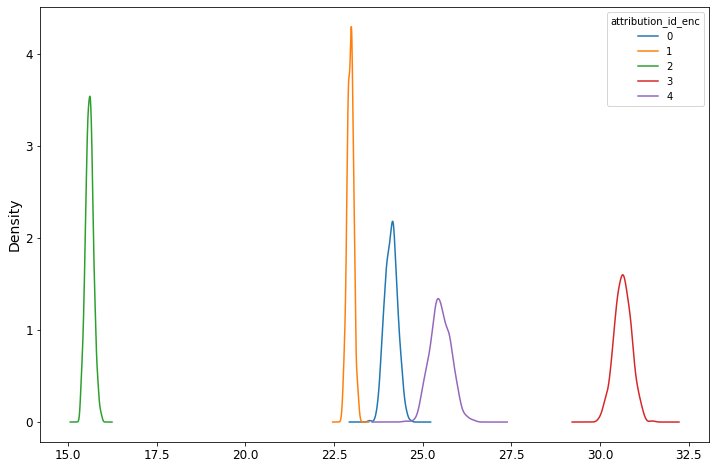

In [0]:
# Creating an list with bootstrapped means for each channel id
boot_channel = []
for i in range(500):
    boot_mean = cart.sample(frac=1, replace=True).groupby('attribution_id_enc')['gmv_a'].mean()
    boot_channel.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_channel = pd.DataFrame(boot_channel)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_channel.plot(kind='kde', figsize=(12, 8))

## The conclusion



The bootstrap result tells us that there is strong evidence that gross merchandise value is the higest at marketing channel id 3 (anonymouse id: 1023896466) among other channels. On the other hand, gross merchandise value is the lowest using channel 2 (anonyouse id: -397064898).

If we want to keep our marketing campaign successful, for the pursuit of large gmv, we should use channel 3 for new campaigns. There are, of course, other metrics we could look at, like looking at the commision rate (the nr over gmv), how many customers use the coupon (if the campaign relates to that). But GMV is the immediate effect of the channel success and more convincing to business stakeholders. GMV is affecting the NR that GYG will have, while the coupon is just a tool for business to generate profits (from GMV).

# Task 3



---


Based on the insight from Task 1, write a short description of an experiment that you would like to run. Please include the details of the experiment, including populations that you are testing, the metrics you would use to evaluate the experiment, and any other relevant information about your experiment design.

**Solution and Justification**

<u>Experiment Background:</u>

As we saw in section 1.2, the activity item `City Cruise` has the highest commision rate (2018: 30%) for GYG, we can think of a marketing campaign to boost sales in next summer.

<u>Target Group</u>:

- GYG registered customers
- One group of customers as control group will not receive the campaign message, the other group should receive the campaign message. Both group of customers should be chosen randomly.

<u>Process</u>:

-- Before the campaign --

* Define the campaign format, release date, duration;
* Randomly choose two groups of customers

-- During the campaign --

* Closely mornitor customers behavior within the campaign duration

-- After the campaign --

* Clean cut and evaluate campaign success

<u>Evaluation Metrics</u>:

AB testing on the average Net Revenue. Evaluating the differrence of NR between these two groups. Using bootstraping to be confident of the results. 

<u>Be Noted</u>:

Try to avoid any confounding effects in this experiment such as seasonality, which will obscure the impacts of campaign. The campaign has a duration. We need to choose the booking entries within the same period for both control and treament group. Other confounding effects may also include different marketing channels, marketing strategy, or even device. Please use only one kind for every attribute in this experiment. 


# Task 4



---


Our Customer Relationship Team occasionally asks us to generate lists from our booking data to send emails to our customers. They ask you to generate a list of customer_id and their first checkout date for a new campaign.

The campaign will be sent to customers who have made their second checkout within 30 days of their first check out. 

Using the fact_checkout table below, write the SQL needed to generate the list.

**Solution and Justification**


```
-- create customer temporary table containing customer_id that have made at least 2 checkout
WITH POTENTIAL_CUSTOMER AS 
(
	 SELECT customer_id_a
	 FROM (
	 	SELECT customer_id_a, COUNT(date_of_checkout) AS num_of_checkout
	 	FROM fact_checkout
	 	GROUP BY 1
	 	HAVING COUNT(date_of_checkout) >=2
	 	)
 ),

-- create checkout temporary table contains the earliest two checkouts from the customer id created earlier 
POTENTIAL_CHECKOUT AS 
(
	SELECT 
		customer_id_a, 
		date_of_checkout, 
		RANK() OVER(PARTITION BY customer_id_a, ORDER BY date_of_checkout) AS payment_order
	FROM fact_checkout
	HAVING payment_order <= 2
	WHERE customer_id_a IN POTENTIAL_CUSTOMER
),

-- create checkout status temporary table with extract columns stating the first and second checkout date
CHECKOUT_STATUS AS 
(
	SELECT 
		customer_id_a, 
		CASE WHEN payment_order = 1 THEN date_of_checkout
			END AS first_checkout_date
		CASE WHEN payment_order = 2 THEN date_of_checkout
			END AS second_checkout_date
	FROM POTENTIAL_CHECKOUT
)

-- extract the needed customer id and their first checkout date whose second checkout date is within 30 days
SELECT 
	customer_id_a, 
	first_checkout_date
FROM CHECKOUT_STATUS
WHERE DATEADD(day, 30, first_checkout_date) <= second_checkout_date;
```

# The end of the test